In [1]:
#########################
### Import Code Stuff ###
#########################

### Numpy and Scipy
import numpy as np
from scipy.stats import binned_statistic
from scipy.optimize import minimize

### Astropy FITS/Table handling
from astropy.io import fits, ascii
from astropy.table import Table, Column

### Matplotlib
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.patches as mpatches
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoMinorLocator
from matplotlib.offsetbox import AnchoredText

### MCMC
import emcee
# import time
import mcmc as mc

### Geometry
import lmcgeometry as lgeo

### Other
import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm_notebook

In [41]:
###################
### Import Data ###
###################

### Import Data
lmc = fits.getdata('/Users/joshuapovick/Desktop/Research/fits/lmc_rgbmembers.r13-l33-58672.fits.gz',1)
cln = np.where((lmc['FE_H']>-9999.0)&(lmc['AK_TARG']>-9999.0)&(lmc['LOGG']>0.0)&(lmc['M_H_ERR']>-90.0)&
                (lmc['C_FE']>-9999.0)&(lmc['N_FE']>-9999.0))

lmc = lmc[cln]

elems = ['M_H','C_FE','N_FE','O_FE','NA_FE','MG_FE','AL_FE','SI_FE','P_FE','S_FE','K_FE','CA_FE','TI_FE',
         'TIII_FE','V_FE','CR_FE','MN_FE','FE_H','CO_FE','NI_FE','CU_FE','GE_FE','RB_FE','CE_FE','ND_FE','YB_FE']
labs = ['[M/H]','[C/Fe]','[N/Fe]','[O/Fe]','[Na/Fe]','[Mg/Fe]','[Al/Fe]','[Si/Fe]','[P/Fe]','[S/Fe]','[K/Fe]',
        '[Ca/Fe]','[Ti/Fe]','[TiII/Fe]','[V/Fe]','[Cr/Fe]','[Mn/Fe]','[Fe/H]','[Co/Fe]','[Ni/Fe]','[Cu/Fe]',
        '[Ge/Fe]','[Rb/Fe]','[Ce/Fe]','[Nd/Fe]','[Yb/Fe]']

### LMC Geometry
x,y,dist = lgeo.LMCdisk_cart(lmc['RA'],lmc['DEC'])
radius = lgeo.elliptical_radius(x,y)

### MCMC Gradients 
overgrads = fits.getdata('mcmc_lmc_grads.fits',0)
younggrads = fits.getdata('mcmc_lmc_grads.fits',1)
ylessgrads = fits.getdata('mcmc_lmc_grads.fits',2)
ymedgrads = fits.getdata('mcmc_lmc_grads.fits',3)
omedgrads = fits.getdata('mcmc_lmc_grads.fits',4)
oldgrads = fits.getdata('mcmc_lmc_grads.fits',5)

### Binned Data
youngtrends = fits.getdata('youngtrends.fits',0)
ylesstrends = fits.getdata('ylesstrends.fits',0)
ymedtrends = fits.getdata('ymedtrends.fits',0)
omedtrends = fits.getdata('omedtrends.fits',0)
oldtrends = fits.getdata('oldtrends.fits',0)

ages = fits.getdata('TEST_pca_ols_ages.fits')

#####################
### Make Age Bins ###
#####################

young = np.where(ages['AGE']<=np.log10(0.5*10**9))
yless = np.where((ages['AGE']>np.log10(0.5*10**9))&(ages['AGE']<=np.log10(2.0*10**9)))
ymed = np.where((ages['AGE']>np.log10(2.0*10**9))&(ages['AGE']<=np.log10(7*10**9)))
omed = np.where((ages['AGE']>np.log10(7*10**9))&(ages['AGE']<=np.log10(10.5*10**9)))
old = np.where(ages['AGE']>np.log10(10.5*10**9))

lmcyoung = lmc[young]
lmcyless = lmc[yless]
lmcymed = lmc[ymed]
lmcomed = lmc[omed]
lmcold = lmc[old]

In [55]:
# prune_fact = 3.0

radiusyoung = radius[young]
radiusyless = radius[yless]
radiusymed = radius[ymed]
radiusomed = radius[omed]
radiusold = radius[old]

### young
young_stats = [] 
young_spread = []

for i in range(len(elems)-5):
    cln = np.where(lmcyoung[elems[i]]>-100.)
    young_cln = np.where(lmcyoung[cln]['SNR']>=100.)
    
    radiusyoung = radius[young][cln][young_cln]
    
    try:
        bins = np.arange(np.floor(np.min(radiusyoung)),np.ceil(np.max(radiusyoung)),1)
        young_bin_stats, _, young_binnumber = binned_statistic(radiusyoung,lmcyoung[elems[i]][young_cln],
                                                                         statistic='median',bins=bins)

        young_mad, _, _ = binned_statistic(radiusyoung,lmcyoung[elems[i]][young_cln],
                                           statistic=lambda y: mc.mad(y),bins=bins)
                                                                        
        young_stats.append(young_bin_stats)
        young_spread.append(young_mad)
    
    except:
        young_stats.append(np.multiply(np.nan,np.ones(len(bins)-1)))
        young_spread.append(np.multiply(np.nan,np.ones(len(bins)-1)))
        
young_stats = np.asarray(young_stats)
young_spread = np.asarray(young_spread)
        
### yless
yless_stats = [] 
yless_spread = []

for i in range(len(elems)-5):
    cln = np.where(lmcyless[elems[i]]>-100.)
    yless_cln = np.where(lmcyless[cln]['SNR']>=100.)
    
    radiusyless = radius[yless][cln][yless_cln]
    
    try:
        bins = np.arange(np.floor(np.min(radiusyless)),np.ceil(np.max(radiusyless)),1)
        yless_bin_stats, _, yless_binnumber = binned_statistic(radiusyless,lmcyless[elems[i]][yless_cln],
                                                                         statistic='median',bins=bins)

        yless_mad, _, _ = binned_statistic(radiusyless,lmcyless[elems[i]][yless_cln],
                                           statistic=lambda y: mc.mad(y),bins=bins)
                                                                        
        yless_stats.append(yless_bin_stats)
        yless_spread.append(yless_mad)
    
    except:
        yless_stats.append(np.multiply(np.nan,np.ones(len(bins)-1)))
        yless_spread.append(np.multiply(np.nan,np.ones(len(bins)-1)))
        
yless_stats = np.asarray(yless_stats)
yless_spread = np.asarray(yless_spread)
        
### ymed
ymed_stats = [] 
ymed_spread = []

for i in range(len(elems)-5):
    cln = np.where(lmcymed[elems[i]]>-100.)
    ymed_cln = np.where(lmcymed[cln]['SNR']>=100.)
    
    radiusymed = radius[ymed][cln][ymed_cln]
    
    try:
        bins = np.arange(np.floor(np.min(radiusymed)),np.ceil(np.max(radiusymed)),1)
        ymed_bin_stats, _, ymed_binnumber = binned_statistic(radiusymed,lmcymed[elems[i]][ymed_cln],
                                                                         statistic='median',bins=bins)

        ymed_mad, _, _ = binned_statistic(radiusymed,lmcymed[elems[i]][ymed_cln],
                                           statistic=lambda y: mc.mad(y),bins=bins)
                                                                        
        ymed_stats.append(ymed_bin_stats)
        ymed_spread.append(ymed_mad)
    
    except:
        ymed_stats.append(np.multiply(np.nan,np.ones(len(bins)-1)))
        ymed_spread.append(np.multiply(np.nan,np.ones(len(bins)-1)))
        
ymed_stats = np.asarray(ymed_stats)
ymed_spread = np.asarray(ymed_spread)
        
### omed
omed_stats = [] 
omed_spread = []

for i in range(len(elems)-5):
    cln = np.where(lmcomed[elems[i]]>-100.)
    omed_cln = np.where(lmcomed[cln]['SNR']>=100.)
    
    radiusomed = radius[omed][cln][omed_cln]
    
    try:
        bins = np.arange(np.floor(np.min(radiusomed)),np.ceil(np.max(radiusomed)),1)
        omed_bin_stats, _, omed_binnumber = binned_statistic(radiusomed,lmcomed[elems[i]][omed_cln],
                                                                         statistic='median',bins=bins)

        omed_mad, _, _ = binned_statistic(radiusomed,lmcomed[elems[i]][omed_cln],
                                           statistic=lambda y: mc.mad(y),bins=bins)
                                                                        
        omed_stats.append(omed_bin_stats)
        omed_spread.append(omed_mad)
    
    except:
        omed_stats.append(np.multiply(np.nan,np.ones(len(bins)-1)))
        omed_spread.append(np.multiply(np.nan,np.ones(len(bins)-1)))
        
omed_stats = np.asarray(omed_stats)
omed_spread = np.asarray(omed_spread)
        
### old
old_stats = [] 
old_spread = []

for i in range(len(elems)-5):
    cln = np.where(lmcold[elems[i]]>-100.)
    old_cln = np.where(lmcold[cln]['SNR']>=100.)
    
    radiusold = radius[old][cln][old_cln]
    
    try:
        bins = np.arange(np.floor(np.min(radiusold)),np.ceil(np.max(radiusold)),1)
        old_bin_stats, _, old_binnumber = binned_statistic(radiusold,lmcold[elems[i]][old_cln],
                                                                         statistic='median',bins=bins)

        old_mad, _, _ = binned_statistic(radiusold,lmcold[elems[i]][old_cln],
                                           statistic=lambda y: mc.mad(y),bins=bins)
                                                                        
        old_stats.append(old_bin_stats)
        old_spread.append(old_mad)
    
    except:
        old_stats.append(np.multiply(np.nan,np.ones(len(bins)-1)))
        old_spread.append(np.multiply(np.nan,np.ones(len(bins)-1)))
        
old_stats = np.asarray(old_stats)
old_spread = np.asarray(old_spread)

In [56]:
old_stats = [] 
old_spread = []

for i in range(len(elems)-5):
    cln = np.where(lmcold[elems[i]]>-100.)
    old_cln = np.where(lmcold[cln]['SNR']>=100.)
    
    radiusold = radius[old][cln][old_cln]
    
    try:
        bins = np.arange(np.floor(np.min(radiusold)),np.ceil(np.max(radiusold)),1)
        old_bin_stats, _, old_binnumber = binned_statistic(radiusold,lmcold[elems[i]][old_cln],
                                                                         statistic='median',bins=bins)

        old_mad, _, _ = binned_statistic(radiusold,lmcold[elems[i]][old_cln],
                                           statistic=lambda y: mc.mad(y),bins=bins)
                                                                        
        old_stats.append(old_bin_stats)
        old_spread.append(old_mad)
    
    except:
        old_stats.append(np.multiply(np.nan,np.ones(len(bins)-1)))
        old_spread.append(np.multiply(np.nan,np.ones(len(bins)-1)))
        
old_stats = np.asarray(old_stats)
old_spread = np.asarray(old_spread)

In [58]:
young_stats

array([[-3.42151552e-01, -3.74711543e-01, -3.84671539e-01,
        -3.59731555e-01, -6.83176517e-01, -1.28396153e+00],
       [-1.85469985e-01, -2.07940012e-01, -1.82620019e-01,
        -1.74119994e-01, -4.34460014e-01, -3.07449996e-01],
       [ 3.75010014e-01,  3.51619989e-01,  3.71010005e-01,
         4.48689997e-01,  2.62165010e-01,  1.16630018e-01],
       [ 1.85699761e-02,  6.20600581e-03,  4.22129929e-02,
         4.68834937e-02,  5.90514988e-02,  2.07735062e-01],
       [-6.21539652e-02, -1.72413915e-01, -1.47593915e-01,
        -8.91789645e-02, -1.09053969e-01, -4.09958959e-01],
       [ 1.41243041e-02,  2.45126784e-02,  5.73216975e-02,
         7.40871876e-02,  7.83282071e-02,  4.91377115e-02],
       [-2.98411489e-01, -2.67501533e-01, -2.57541567e-01,
        -2.16861501e-01, -3.05151522e-01, -3.24671507e-01],
       [ 2.23340094e-02,  1.48659945e-02,  4.96020317e-02,
         5.71604967e-02,  5.60090095e-02,  1.11871958e-01],
       [ 8.12469721e-02,  7.34070241e-02,  7.884

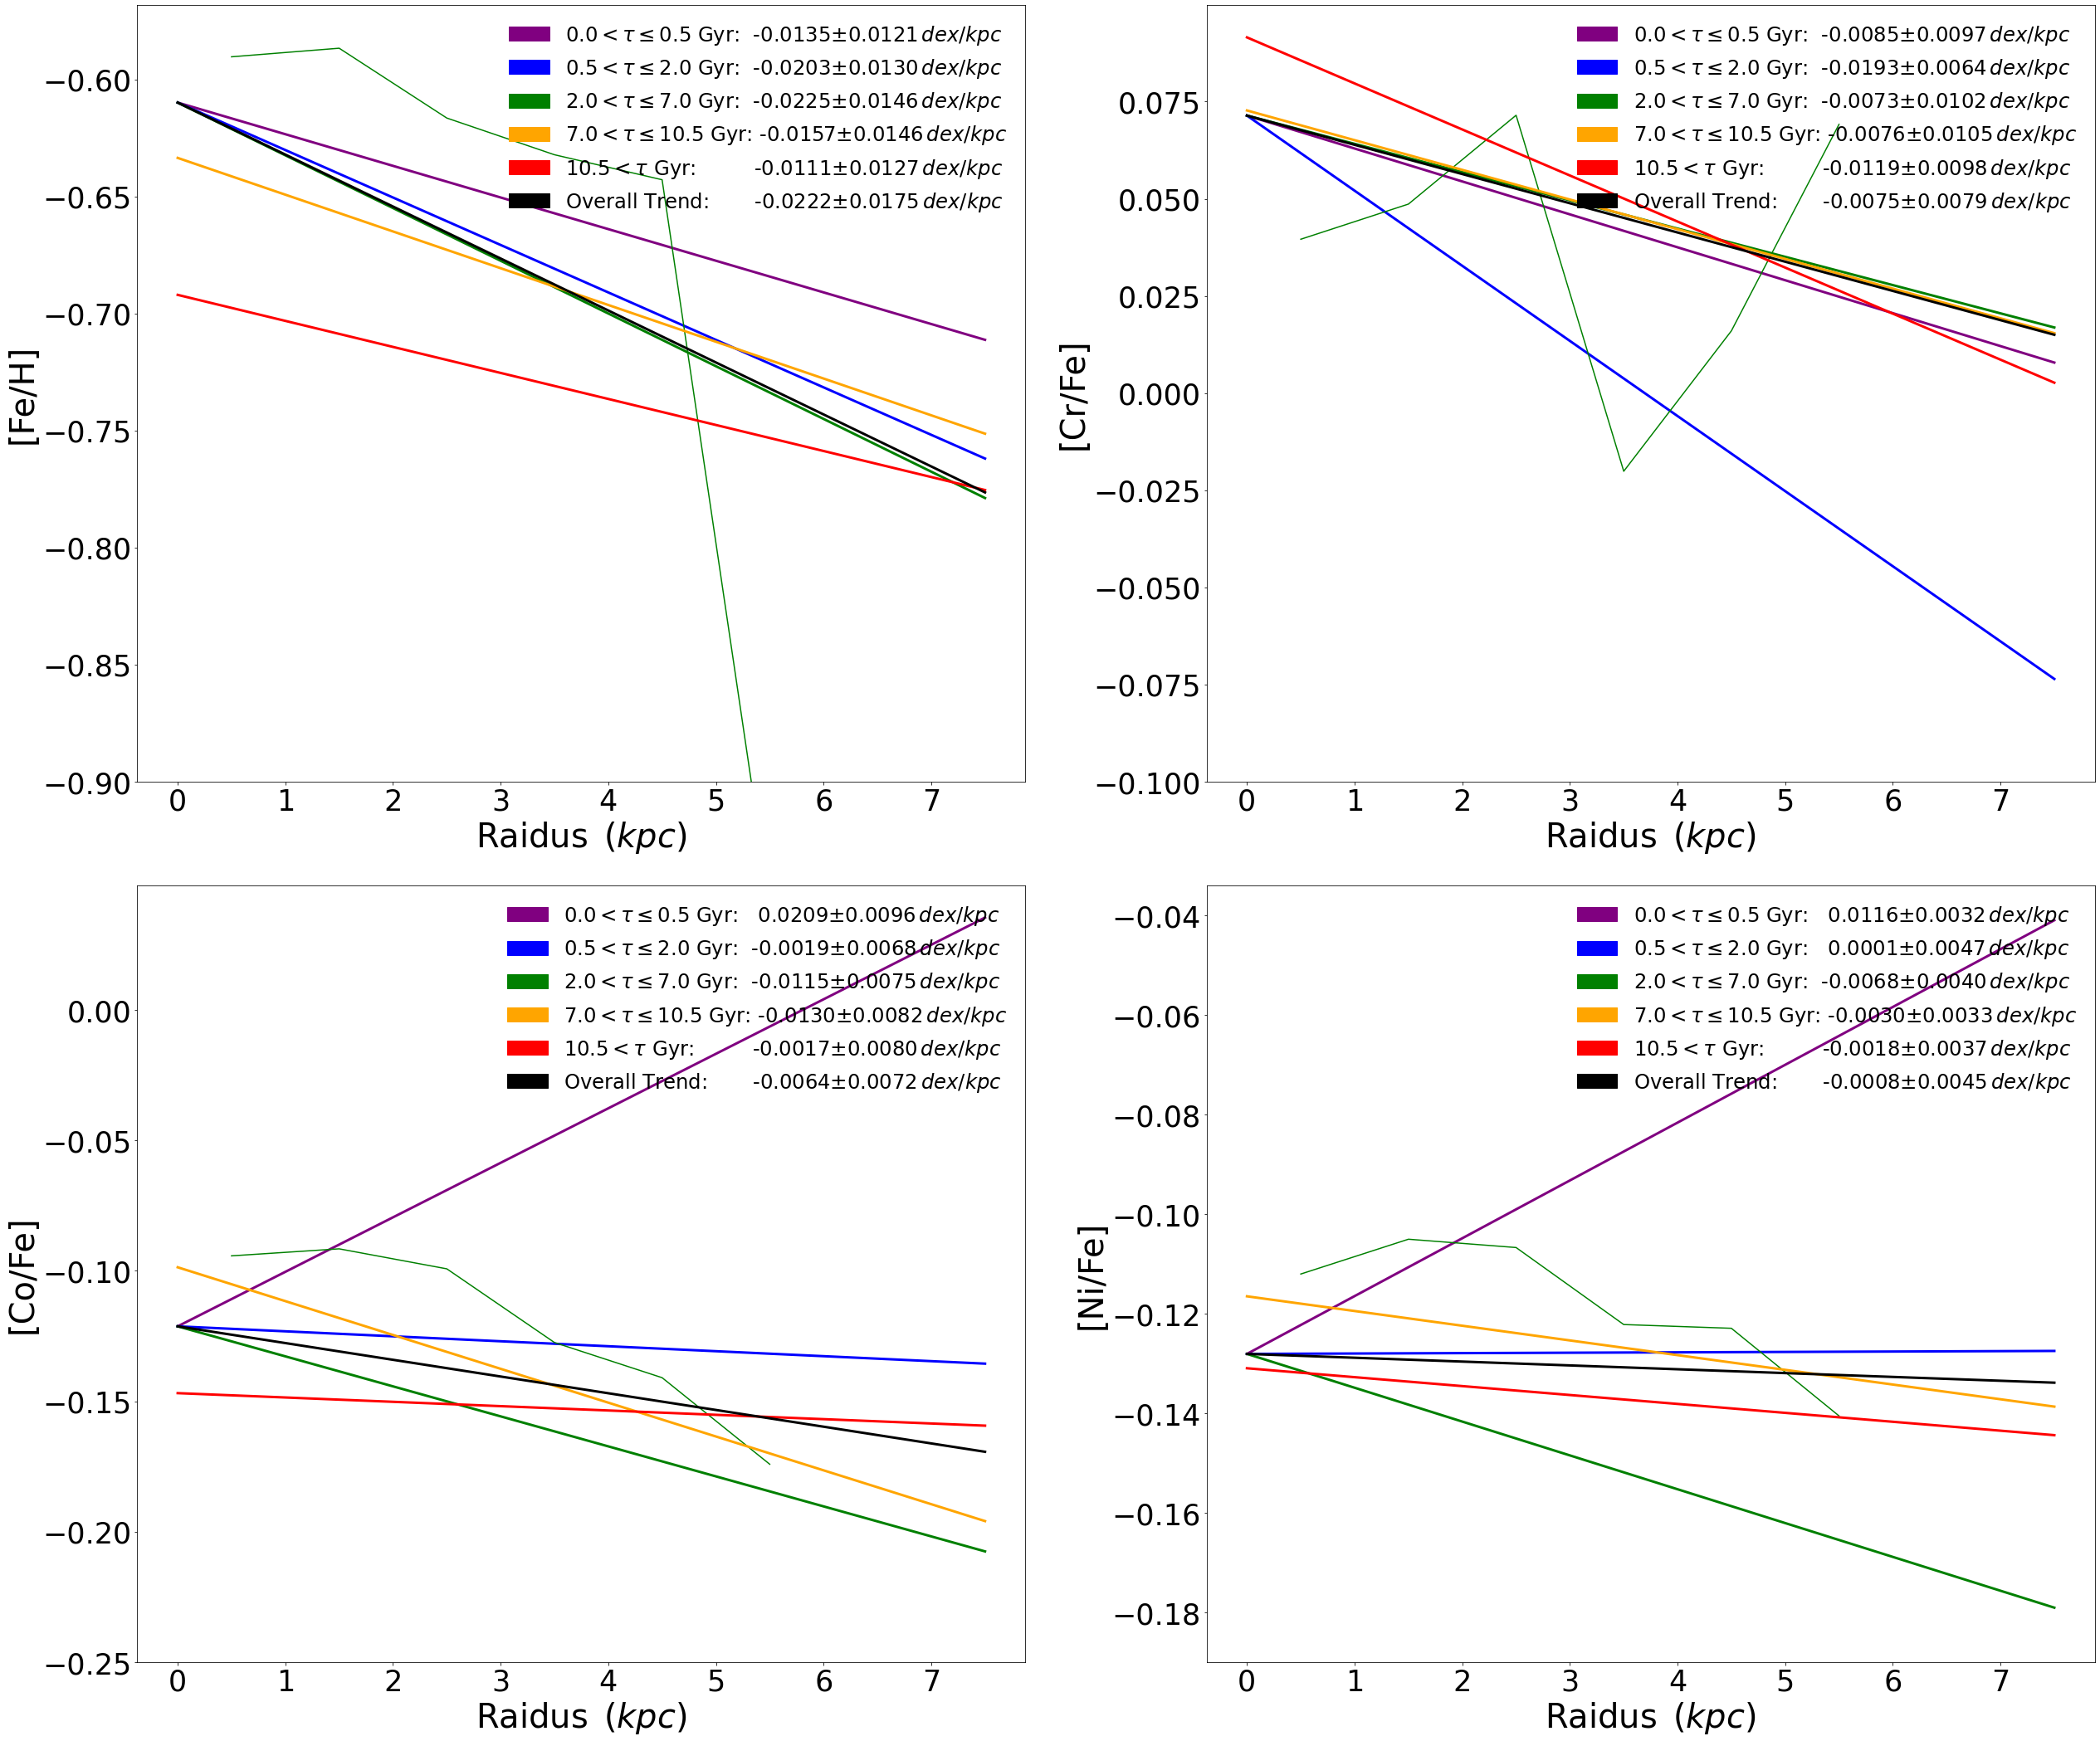

In [59]:
iron = [int(np.squeeze(np.where(np.asarray(labs)=='[Fe/H]'))),
        int(np.squeeze(np.where(np.asarray(labs)=='[Cr/Fe]'))),
        int(np.squeeze(np.where(np.asarray(labs)=='[Co/Fe]'))),
        int(np.squeeze(np.where(np.asarray(labs)=='[Ni/Fe]')))]

iron_sub = [221,222,223,224]

bottoms = [-0.9,-0.1,-0.25,-0.19]

matplotlib.rcParams.update({'font.size': 35})

plt.figure(figsize=[36,30])

for i,j in enumerate(iron): #range(len(iron)):
    xval = np.linspace(0.0,7.5)
    
    def youngtrendline(x):
        return younggrads['GRAD'][j]*x+younggrads['INTER'][j]
    def ylesstrendline(x):
        return ylessgrads['GRAD'][j]*x+ylessgrads['INTER'][j]
    def ymedtrendline(x):
        return ymedgrads['GRAD'][j]*x+ymedgrads['INTER'][j]
    def omedtrendline(x):
        return omedgrads['GRAD'][j]*x+omedgrads['INTER'][j]
    def oldtrendline(x):
        return oldgrads['GRAD'][j]*x+oldgrads['INTER'][j]
    def overtrendline(x):
        return overgrads['GRAD'][j]*x+overgrads['INTER'][j]
        
    plt.subplot(iron_sub[i])
    
    ### young
#     plt.errorbar(np.arange(len(younggrads['GRAD_ERR'][j]))+0.5+0.25,younggrads['GRAD_ERR'][j],
#                  yerr=youngrads['GRAD_ERR'][j],color='purple',ls='--',alpha=0.75,lw=1)
#     plt.plot(np.arange(len(young_stats[j]))+0.5+0.25,youngtrends['STATS'][j],color='purple')
    plt.plot(xval,youngtrendline(xval),c='purple',lw=3.0,ls='-') #young
    
#     ### yless
#     plt.errorbar(np.arange(len(ylesstrends['STATS'][j]))+0.5+0.125,ylesstrends['STATS'][j],
#                  yerr=ylesstrends['SPREAD'][j],color='blue',ls='-',alpha=0.75,lw=1)
#     plt.plot(np.arange(len(yless_stats[j]))+0.5+0.125,yless_stats[j],color='blue')
    plt.plot(xval,ylesstrendline(xval),c='blue',lw=3.0,ls='-') #yless
    
#     ### ymed
#     plt.errorbar(np.arange(len(ymedtrends['STATS'][j]))+0.5,ymedtrends['STATS'][j],
#                  yerr=ymedtrends['SPREAD'][j],color='green',ls='-',alpha=0.75,lw=1)
    plt.plot(np.arange(len(ymed_stats[j]))+0.5,ymed_stats[j],color='green')
    plt.plot(xval,ymedtrendline(xval),c='green',lw=3.0,ls='-') #ymed

#     ### omed
#     plt.errorbar(np.arange(len(omedtrends['STATS'][j]))+0.5-0.125,omedtrends['STATS'][j],
#                  yerr=omedtrends['SPREAD'][j],color='orange',ls='-',alpha=0.75,lw=1)
#     plt.plot(np.arange(len(omed_stats[j]))+0.5-0.125,omed_stats[j],color='orange')
    plt.plot(xval,omedtrendline(xval),c='orange',lw=3.0,ls='-') #omed
    

#     ### old
#     plt.errorbar(np.arange(len(oldtrends['STATS'][j]))+0.5-0.25,oldtrends['STATS'][j],
#                  yerr=oldtrends['SPREAD'][j],color='red',ls='-',alpha=0.75,lw=1)
#     plt.plot(np.arange(len(old_stats[j]))+0.5-0.25,old_stats[j],color='red')
    plt.plot(xval,oldtrendline(xval),c='red',lw=3.0,ls='-') #old
    
#     ### overall
    plt.plot(xval,overtrendline(xval),c='k',lw=3.0)
    
    handles,labels = plt.gca().get_legend_handles_labels()
    empty_young = mpatches.Patch(color='purple',label='$0.0 < \\tau \leq 0.5$ Gyr')
    empty_yless = mpatches.Patch(color='blue',label='$0.5 < \\tau \leq 2.0$ Gyr')
    empty_ymed = mpatches.Patch(color='green',label='$2.0 < \\tau \leq 7.0$ Gyr')
    empty_omed = mpatches.Patch(color='orange',label='$7.0 < \\tau \leq 10.5$ Gyr')
    empty_old = mpatches.Patch(color='red',label='$10.5 < \\tau$ Gyr')
    empty_over = mpatches.Patch(color='black',label='Overall Trend')
    
    handles.append(empty_young)
    handles.append(empty_yless)
    handles.append(empty_ymed)
    handles.append(empty_omed)
    handles.append(empty_old)
    handles.append(empty_over)
    
    labels.append('$0.0 < \\tau \leq 0.5$ Gyr: {:>8.4f}$\pm {:.4f} \,dex/kpc$'.format(younggrads['GRAD'][j],
                                                                                      younggrads['GRAD_ERR'][j]))
    labels.append('$0.5 < \\tau \leq 2.0$ Gyr: {:>8.4f}$\pm {:.4f} \,dex/kpc$'.format(ylessgrads['GRAD'][j],
                                                                                      ylessgrads['GRAD_ERR'][j]))
    labels.append('$2.0 < \\tau \leq 7.0$ Gyr: {:>8.4f}$\pm {:.4f} \,dex/kpc$'.format(ymedgrads['GRAD'][j],
                                                                                      ymedgrads['GRAD_ERR'][j]))
    labels.append('$7.0 < \\tau \leq 10.5$ Gyr: {:>5.4f}$\pm {:.4f} \,dex/kpc$'.format(omedgrads['GRAD'][j],
                                                                                       omedgrads['GRAD_ERR'][j]))
    labels.append('$10.5 < \\tau$ Gyr: {:>15.4f}$\pm {:.4f} \,dex/kpc$'.format(oldgrads['GRAD'][j],
                                                                               oldgrads['GRAD_ERR'][j]))
    labels.append('Overall Trend: {:>13.4f}$\pm {:.4f} \,dex/kpc$'.format(overgrads['GRAD'][j],
                                                                          overgrads['GRAD_ERR'][j]))
    
    plt.legend(handles,labels,loc='upper right',fontsize='x-small',frameon=False)
    
    label_y = [-0.3075,0.1375,0.015,-0.061]
    
#     plt.text(0,label_y[i],'{}'.format(labs[j]),fontsize=50)

    plt.ylim(bottom = bottoms[i])
    
    if labs[i] == 'CR_FE':
        plt.ylim(top = -0.06)
        
    if labs[i] == 'FE_H':
        plt.ylim(top=1.0)

    plt.ylabel(r'{}'.format(labs[j]),fontsize=40)
    plt.xlabel(r'Raidus $\,(kpc$)',fontsize=40)
    
plt.tight_layout()
plt.savefig('ironTrends.pdf',bbox_inches='tight')
plt.show()

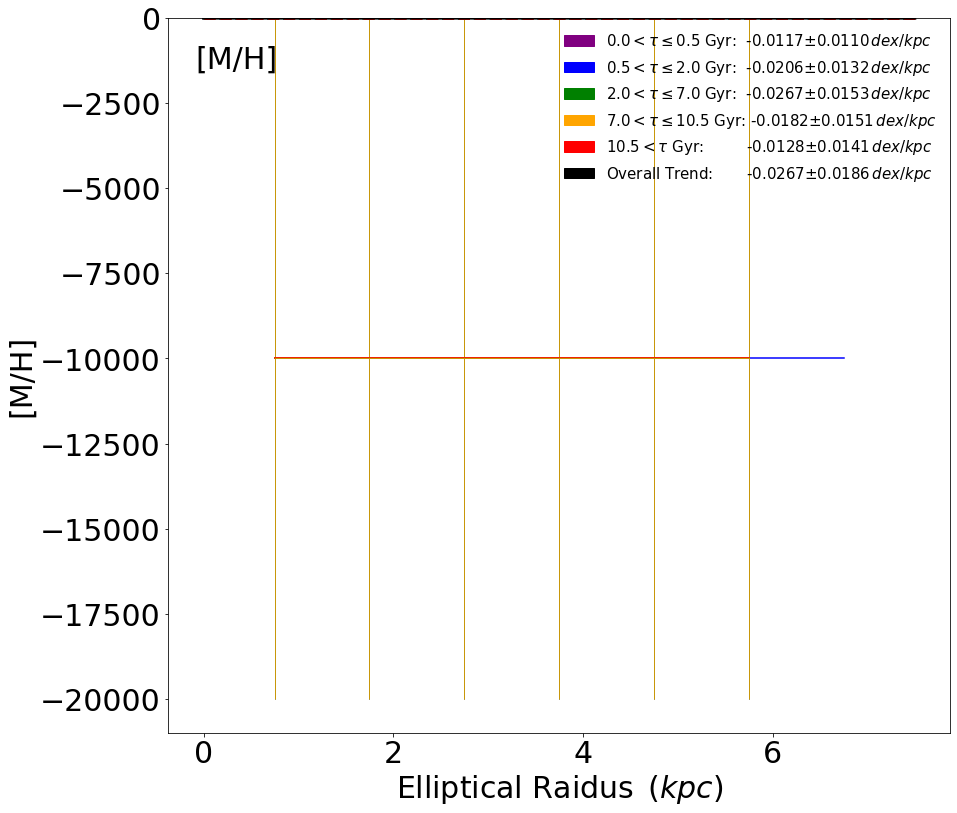

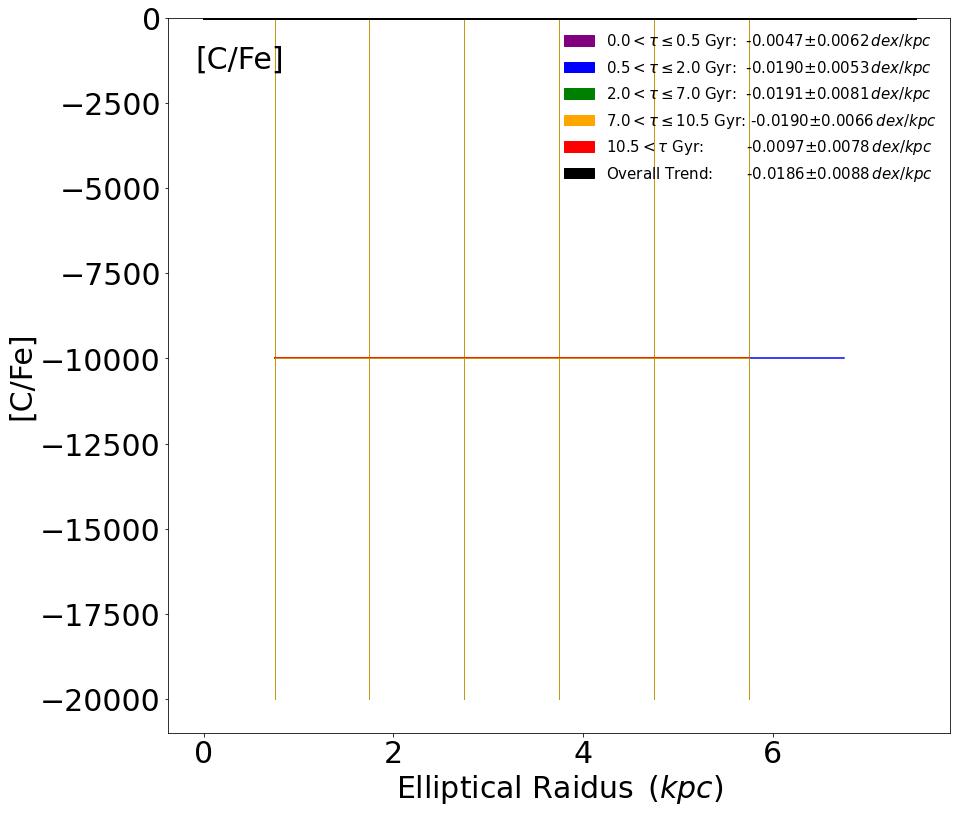

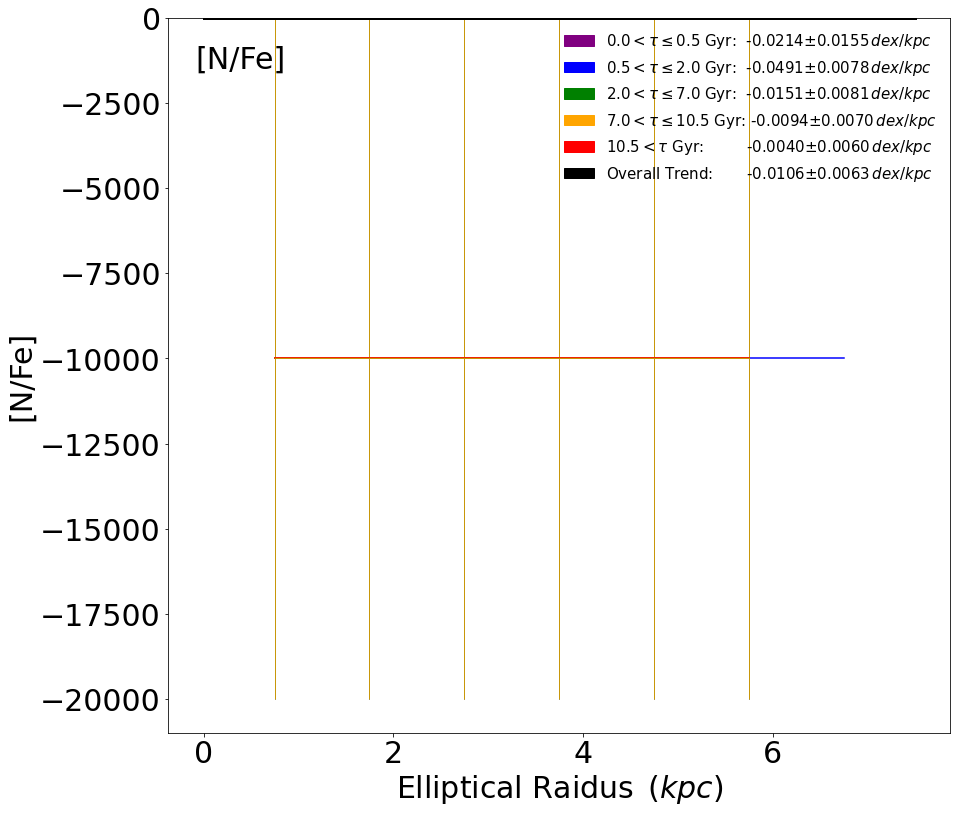

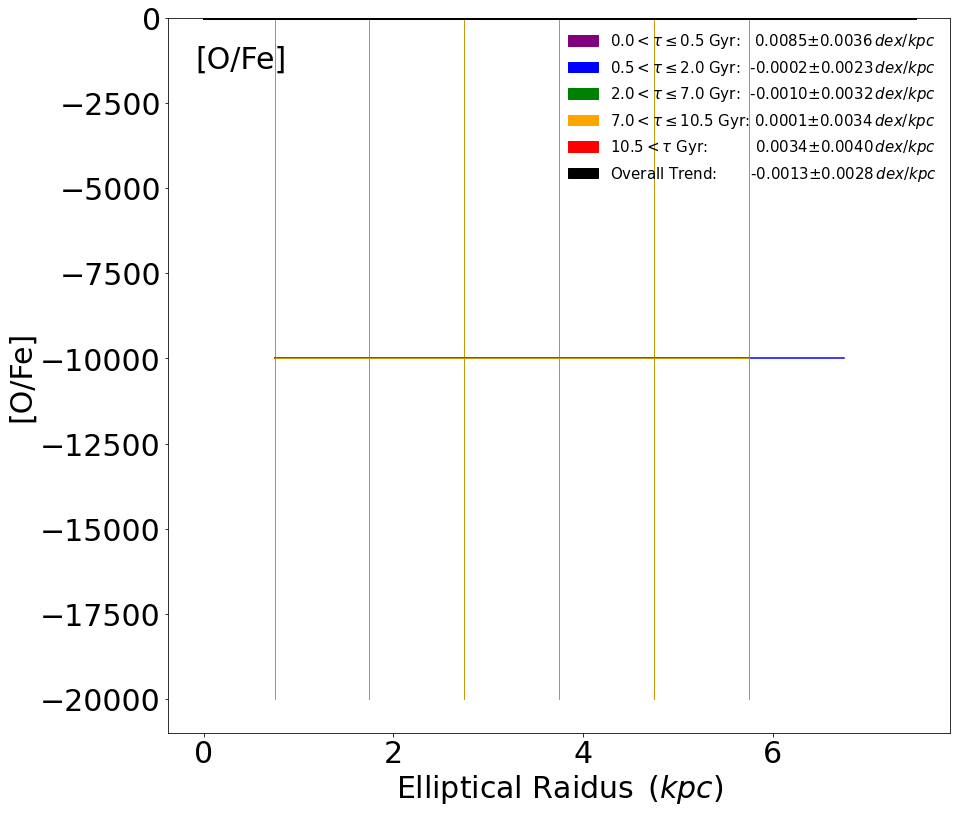

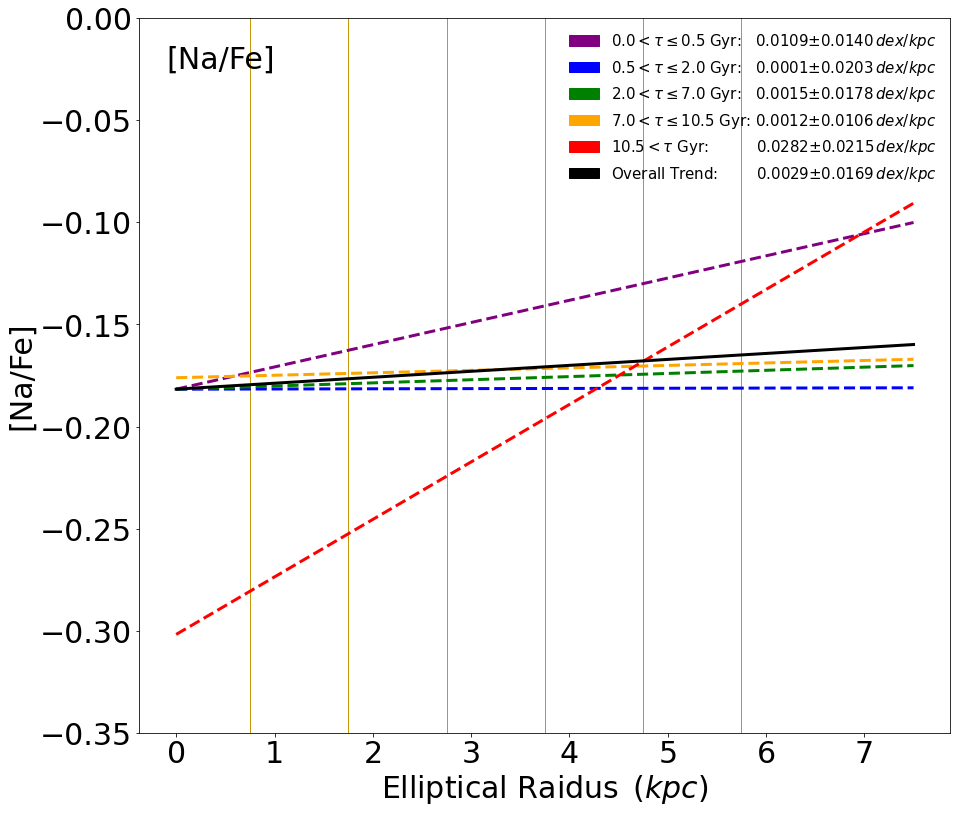

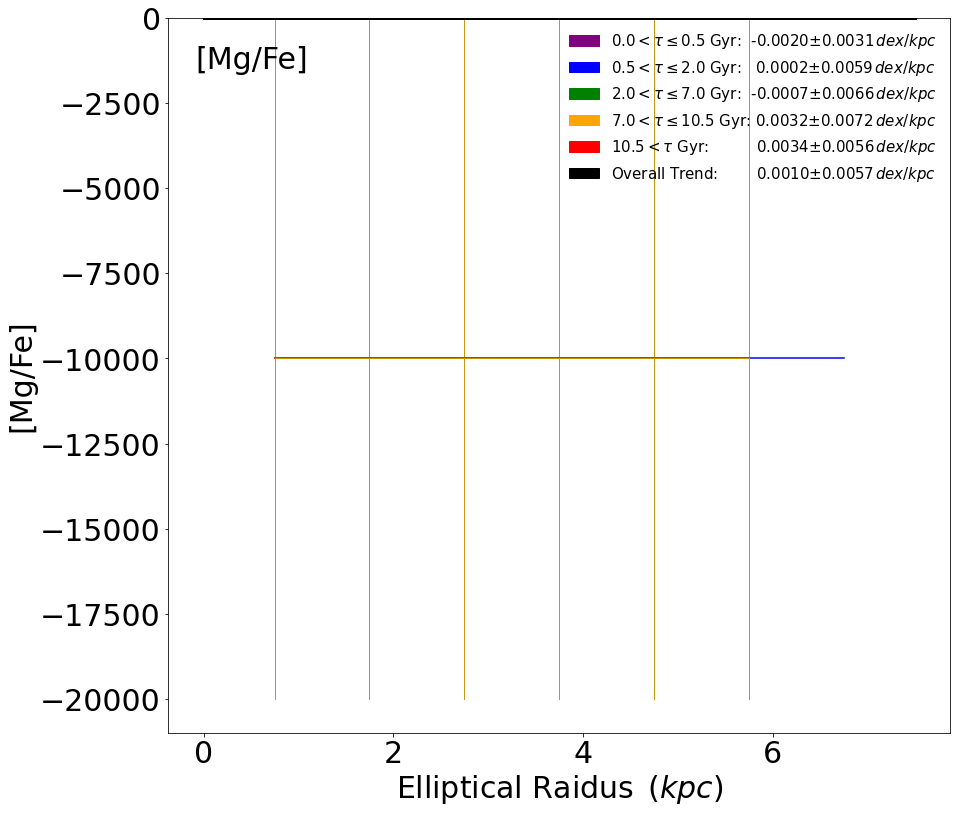

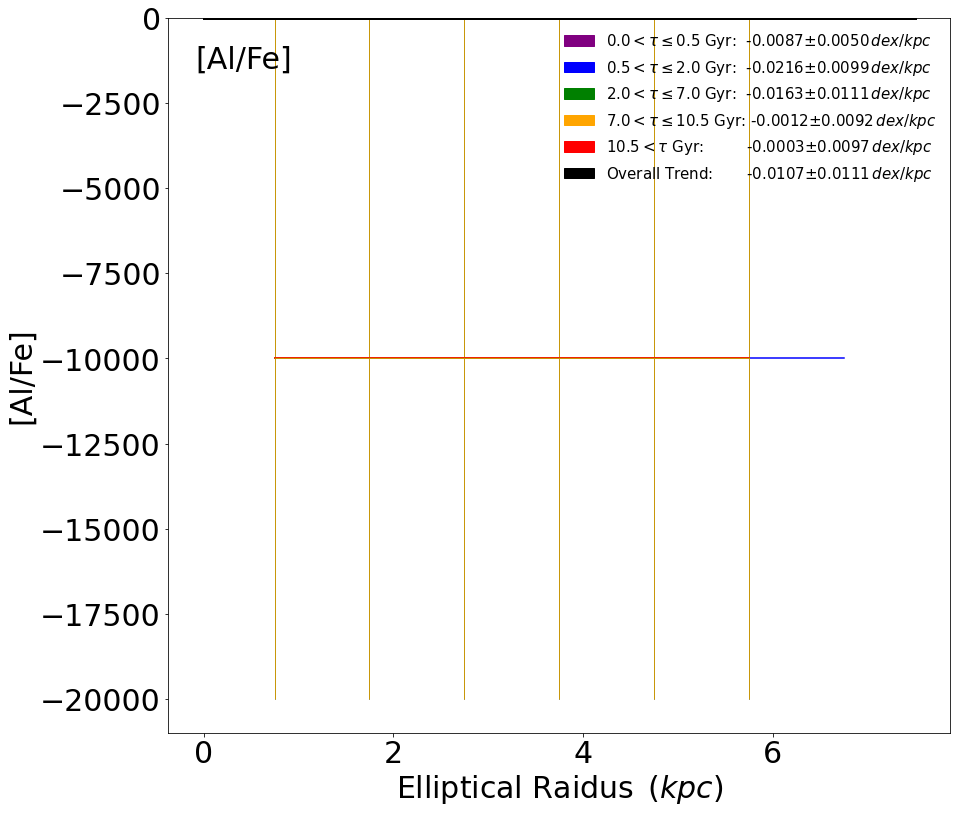

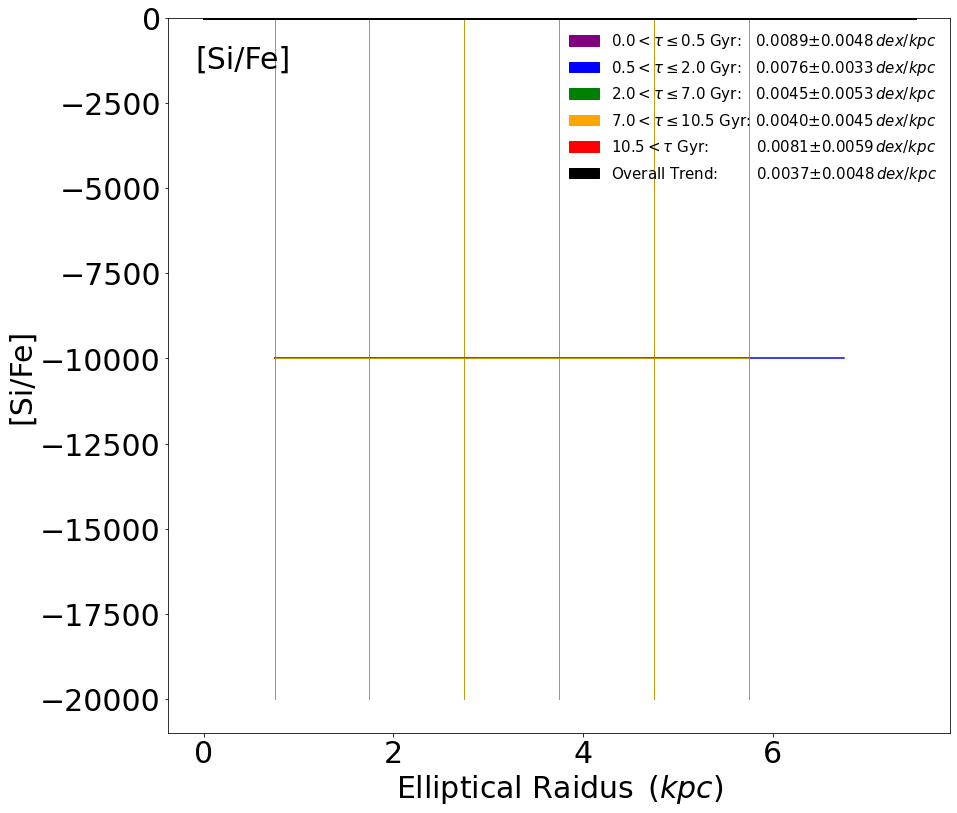

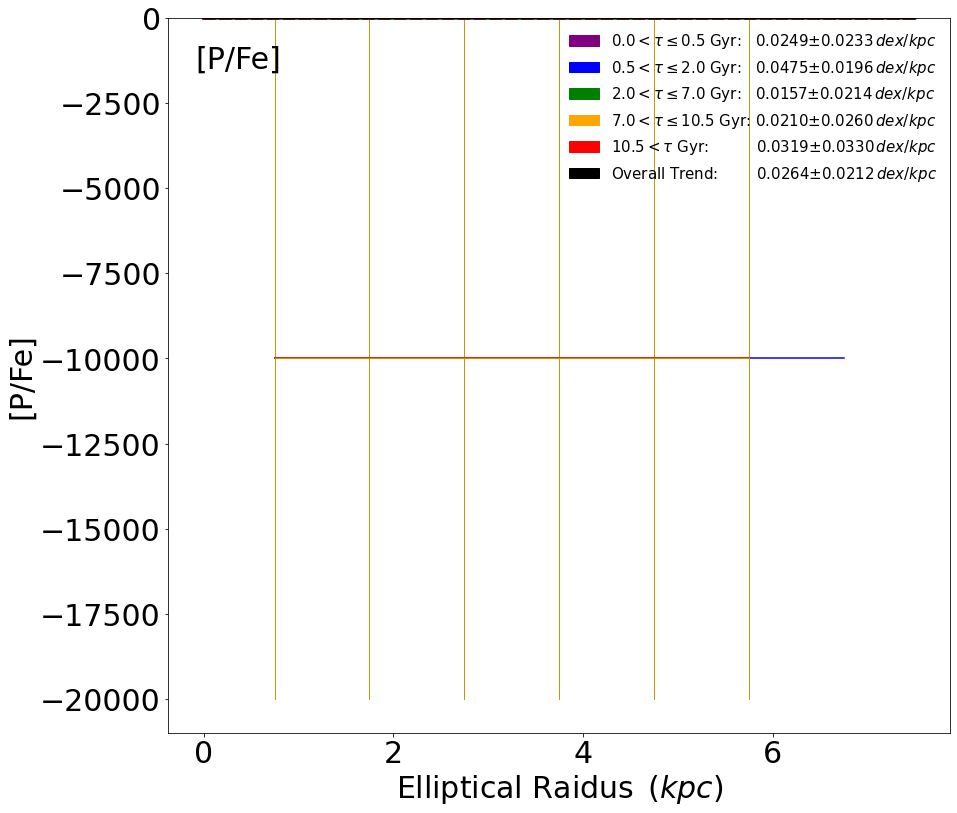

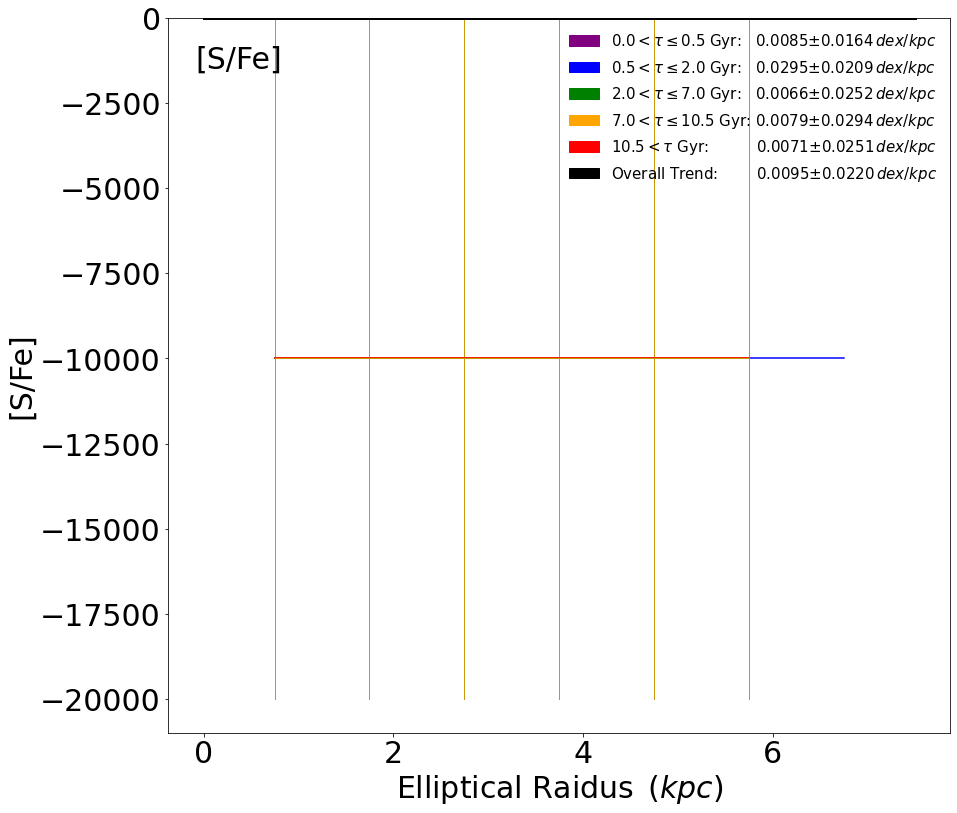

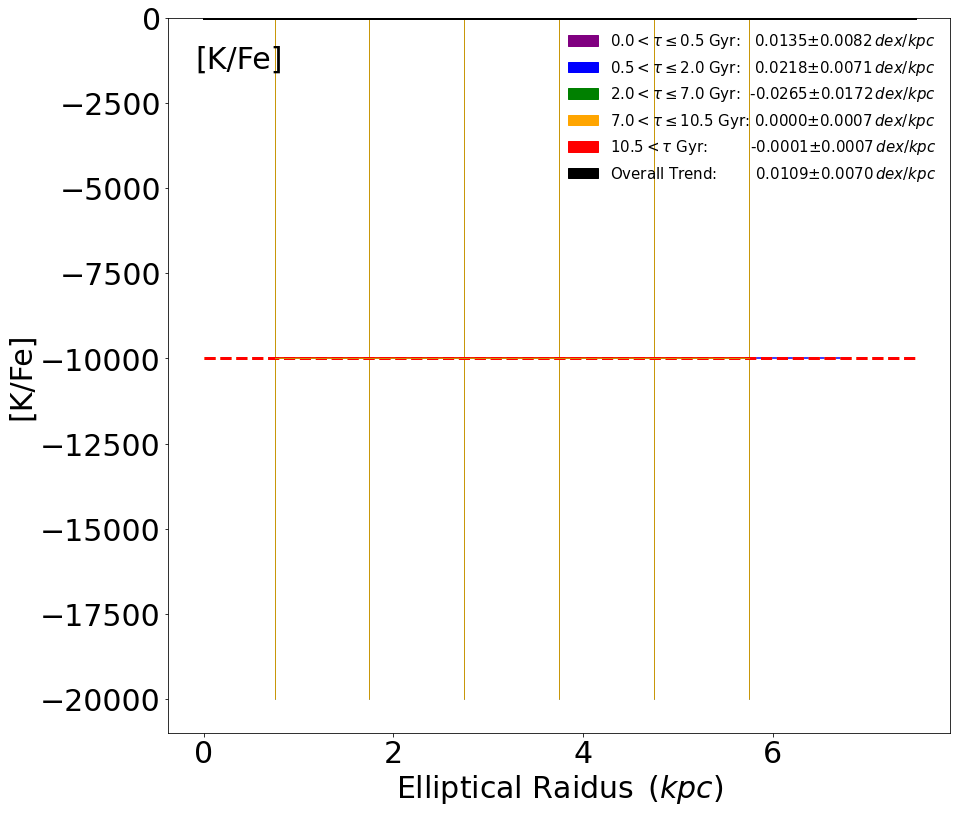

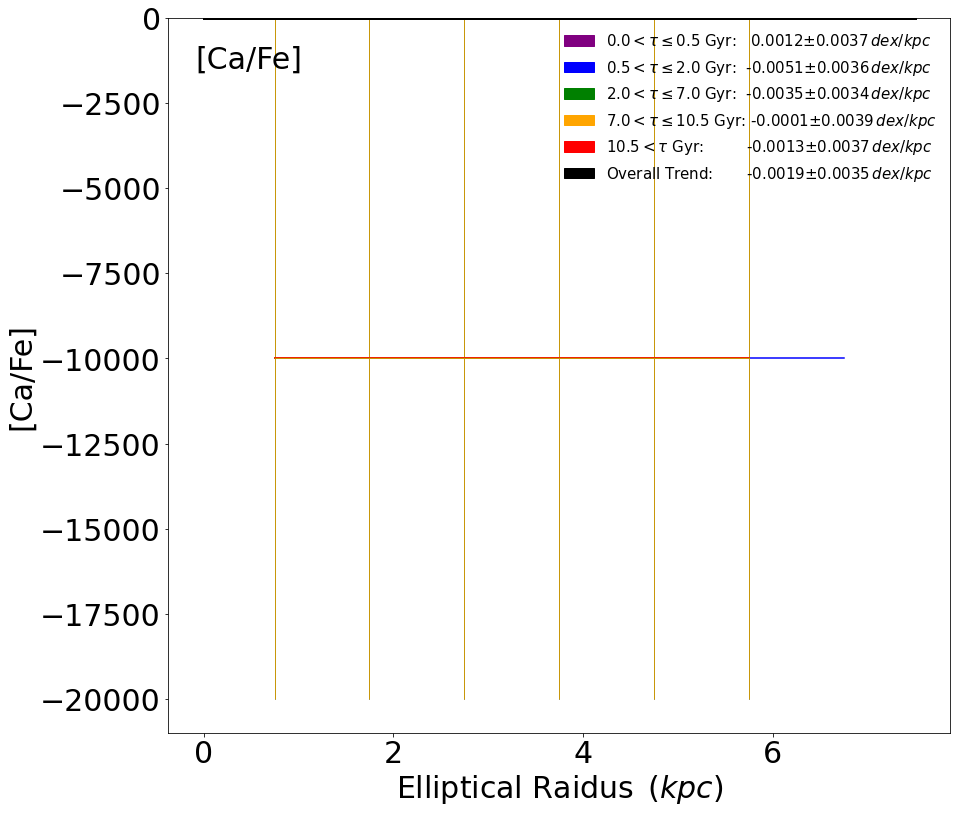

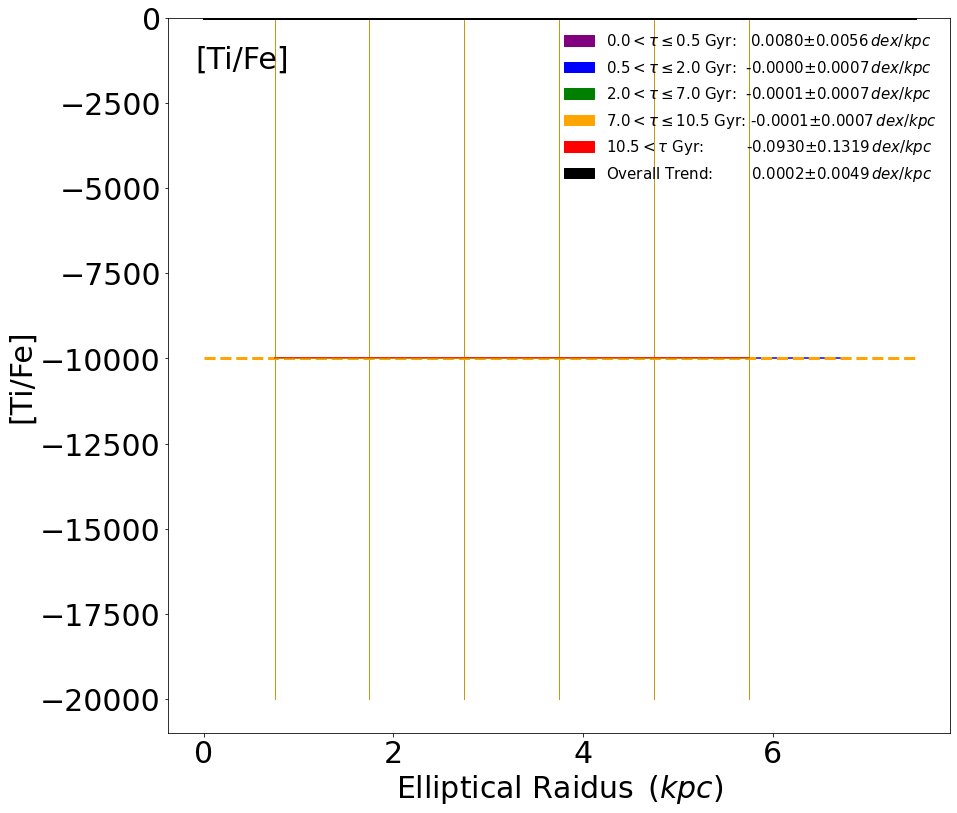

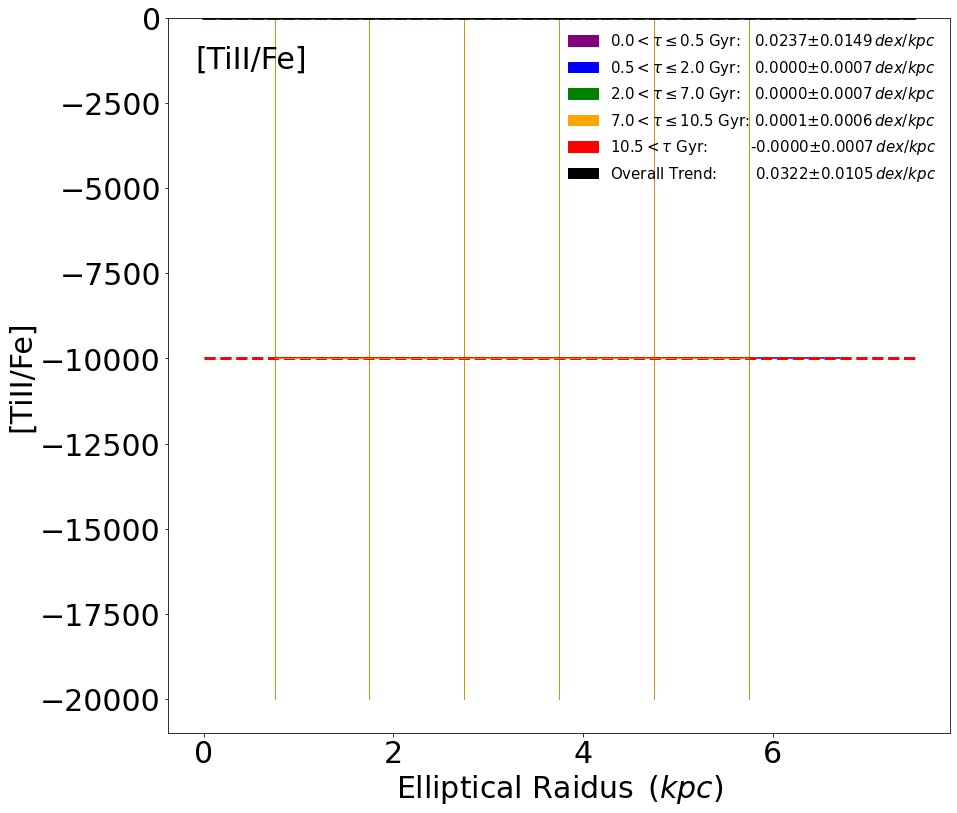

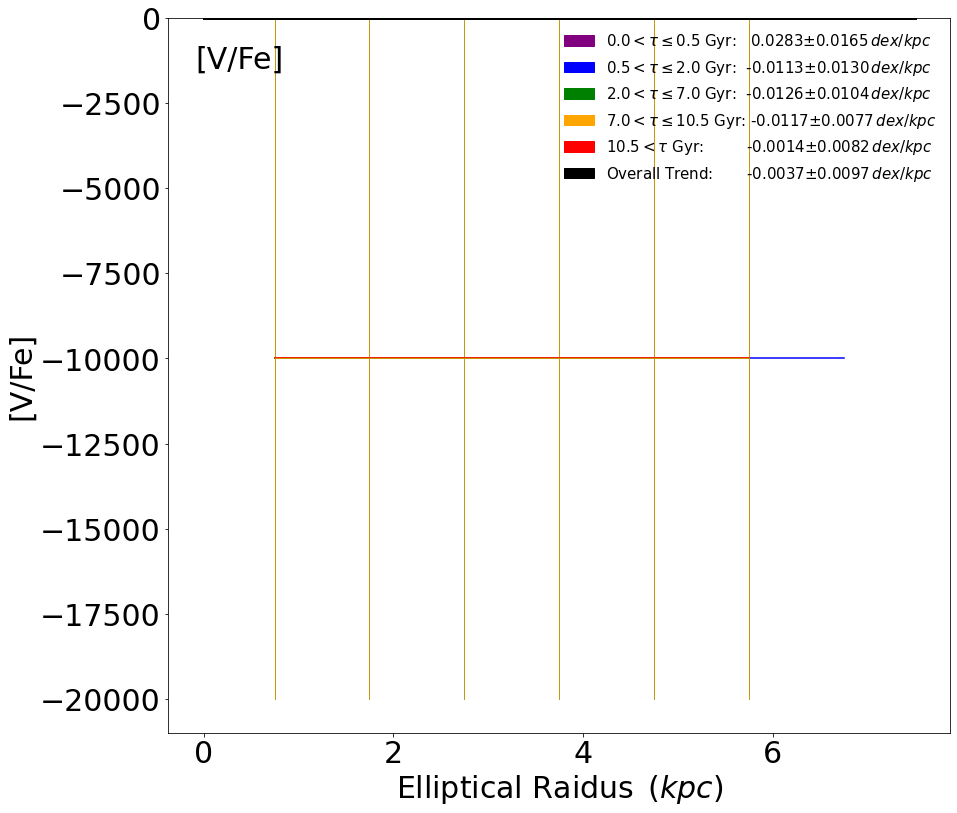

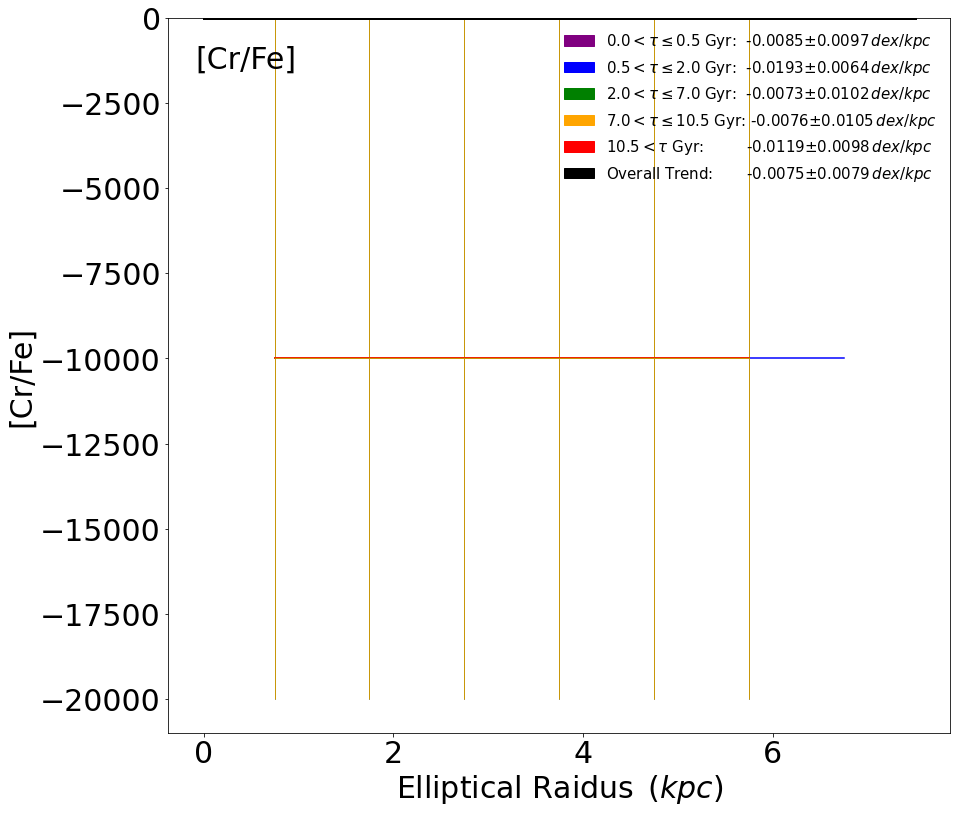

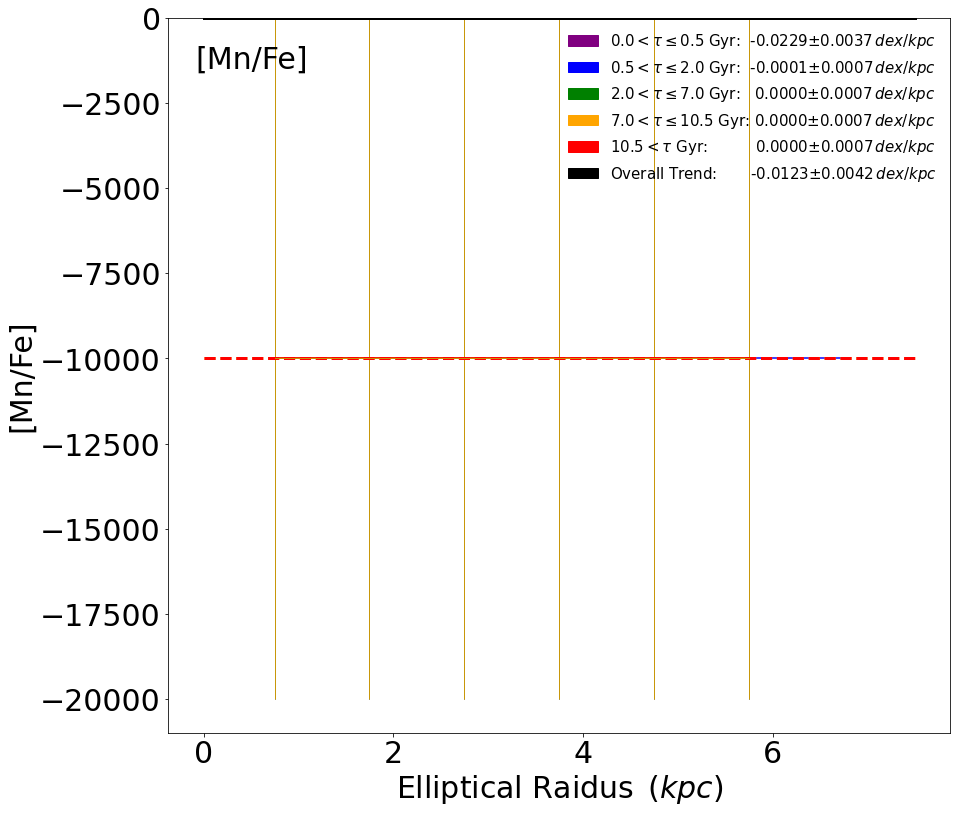

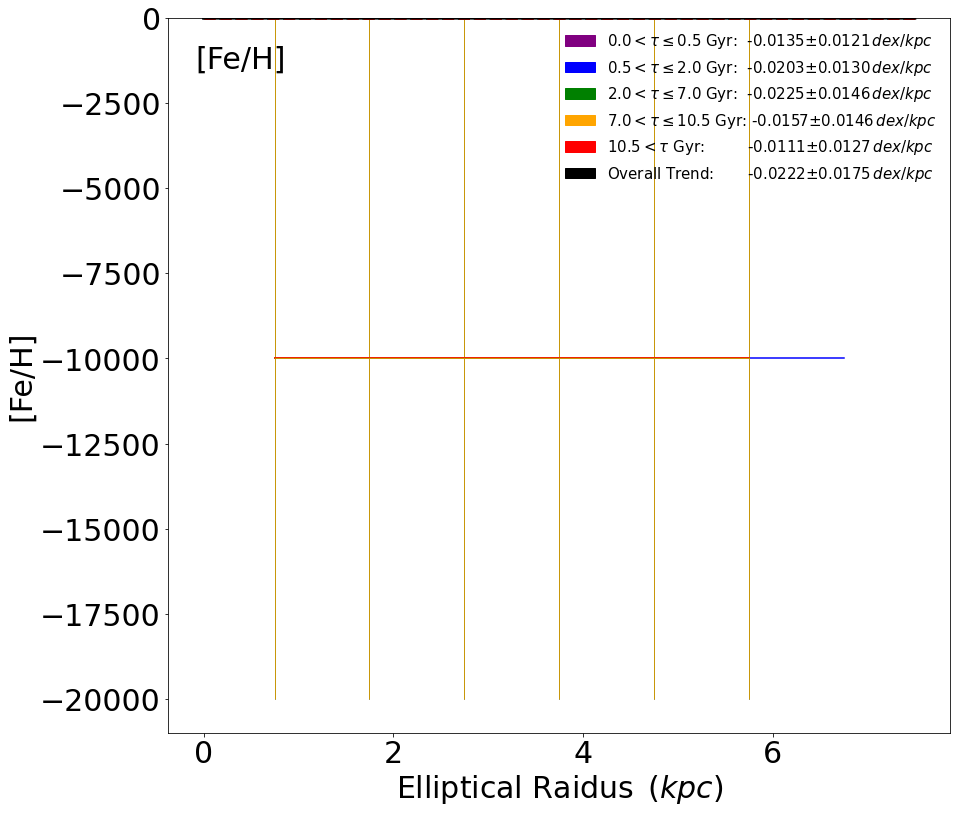

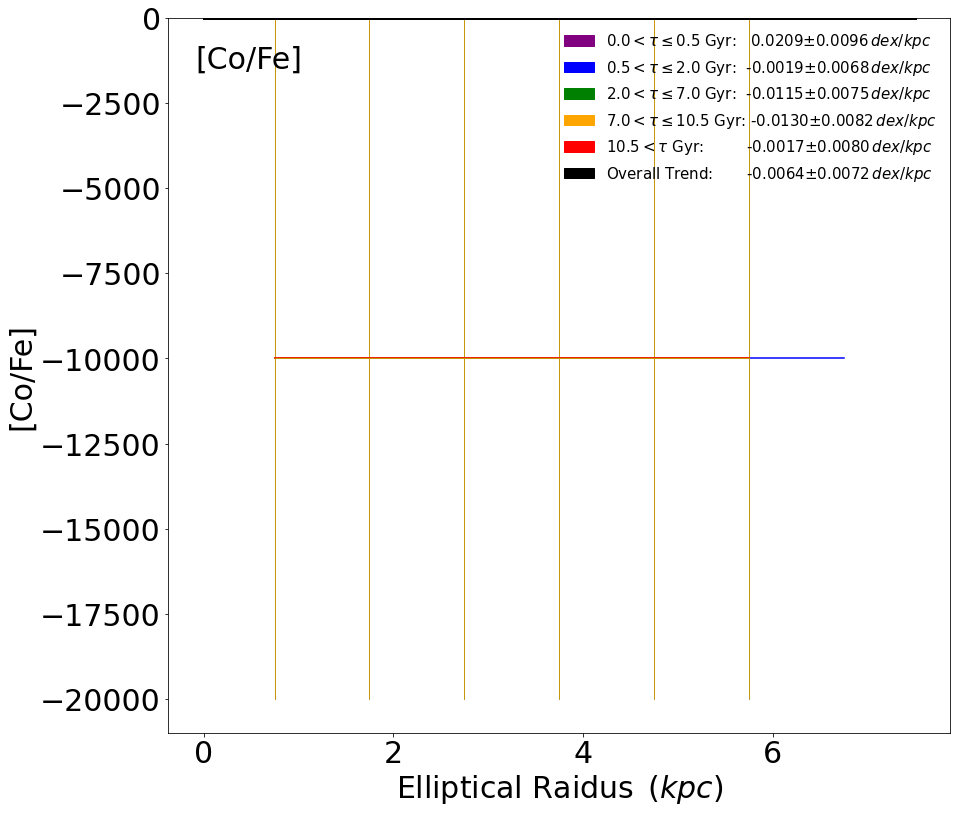

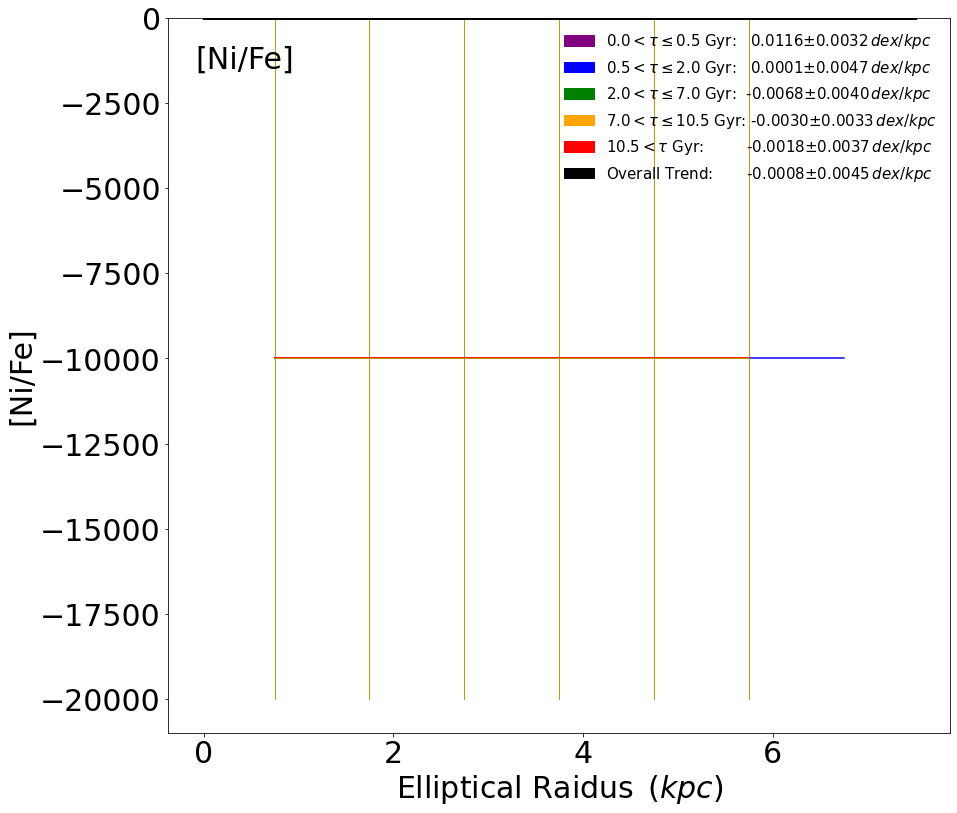

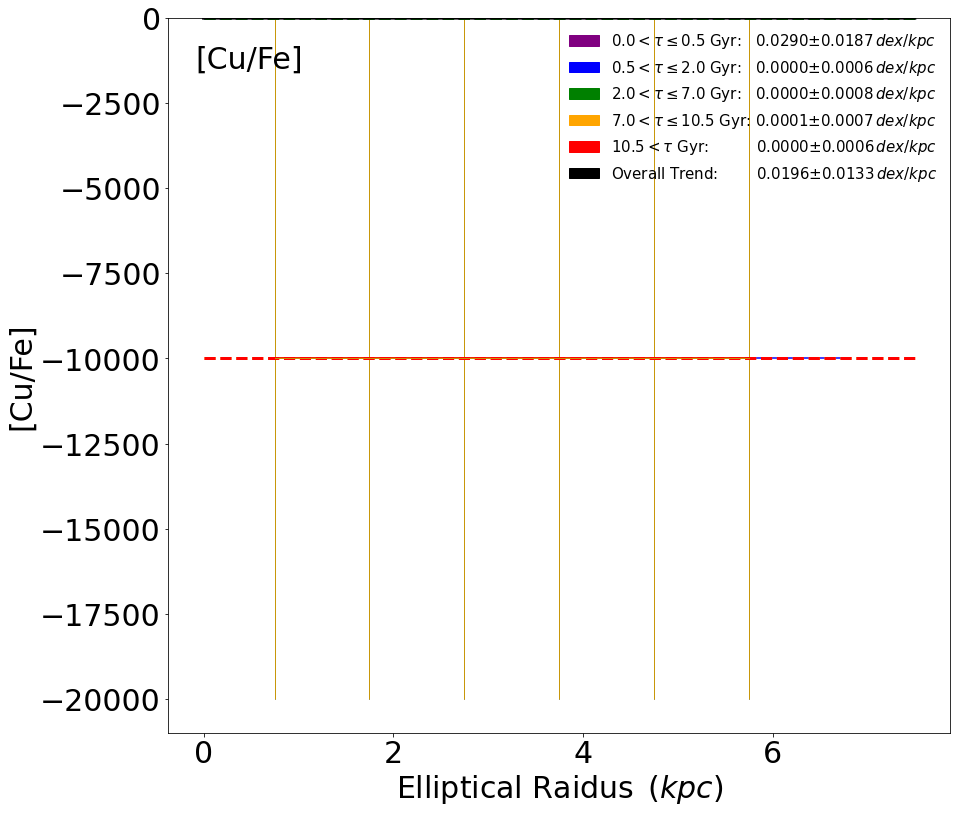

In [40]:
ytops = [0,0.1,0.7,0.2,1.0,0.4,0,0.325,2.0,0.8,0.8,0.3,0,0,0.75,0.4,0,0.0,0.5,0.0,0,0,0,0,0,0]

matplotlib.rcParams.update({'font.size': 30})
import matplotlib.patches as mpatches

young_parage = np.asarray(ages)[young]
yless_parage = np.asarray(ages)[yless]
ymed_parage = np.asarray(ages)[ymed]
omed_parage = np.asarray(ages)[omed]
old_parage = np.asarray(ages)[old]

for i in tqdm_notebook(range(len(elems)-5),desc='plots',leave=False):
    xval = np.linspace(0.0,7.5)
    
    def youngtrendline(x):
        return younggrads['GRAD'][i]*x+younggrads['INTER'][i]
    def ylesstrendline(x):
        return ylessgrads['GRAD'][i]*x+ylessgrads['INTER'][i]
    def ymedtrendline(x):
        return ymedgrads['GRAD'][i]*x+ymedgrads['INTER'][i]
    def omedtrendline(x):
        return omedgrads['GRAD'][i]*x+omedgrads['INTER'][i]
    def oldtrendline(x):
        return oldgrads['GRAD'][i]*x+oldgrads['INTER'][i]
    def trendline(x):
        return overgrads['GRAD'][i]*x+overgrads['INTER'][i]
        
    fig = plt.figure(figsize=[14,12])
    
    ### young
    plt.errorbar(np.arange(len(youngtrends['STATS'][i]))+0.5+0.25,youngtrends['STATS'][i],
                 yerr=youngtrends['SPREAD'][i],color='purple',ls='-',alpha=0.75,lw=1)
    plt.plot(np.arange(len(youngtrends['STATS'][i]))+0.5+0.25,youngtrends['STATS'][i],color='purple')
    plt.plot(xval,youngtrendline(xval),c='purple',lw=3.0,ls='--') #young
    
    ### yless
#     plt.errorbar(np.arange(len(ylesstrends['STATS'][i]))+0.5+0.25,ylesstrends['STATS'][i],
#                  yerr=ylesstrends['SPREAD'][i],color='blue',ls='-',alpha=0.75,lw=1)
    plt.plot(np.arange(len(ylesstrends['STATS'][i]))+0.5+0.25,ylesstrends['STATS'][i],color='blue')
    plt.plot(xval,ylesstrendline(xval),c='blue',lw=3.0,ls='--') #yless
    
    ### ymed
    plt.errorbar(np.arange(len(ymedtrends['STATS'][i]))+0.5+0.25,ymedtrends['STATS'][i],
                 yerr=ymedtrends['SPREAD'][i],color='green',ls='-',alpha=0.75,lw=1)
    plt.plot(np.arange(len(ymedtrends['STATS'][i]))+0.5+0.25,ymedtrends['STATS'][i],color='green')
    plt.plot(xval,ymedtrendline(xval),c='green',lw=3.0,ls='--') #ymed

    ### omed
    plt.errorbar(np.arange(len(omedtrends['STATS'][i]))+0.5+0.25,omedtrends['STATS'][i],
                 yerr=omedtrends['SPREAD'][i],color='orange',ls='-',alpha=0.75,lw=1)
    plt.plot(np.arange(len(omedtrends['STATS'][i]))+0.5+0.25,omedtrends['STATS'][i],color='orange')
    plt.plot(xval,omedtrendline(xval),c='orange',lw=3.0,ls='--') #omed
    

    ### old
#     plt.errorbar(np.arange(len(oldtrends['STATS'][i]))+0.5+0.25,oldtrends['STATS'][i],
#                  yerr=oldtrends['SPREAD'][i],color='red',ls='-',alpha=0.75,lw=1)
    plt.plot(np.arange(len(oldtrends['STATS'][i]))+0.5+0.25,oldtrends['STATS'][i],color='red')
    plt.plot(xval,oldtrendline(xval),c='red',lw=3.0,ls='--') #old
    
    ### overall
    plt.plot(xval,trendline(xval),c='k',lw=3.0)
    
    handles,labels = plt.gca().get_legend_handles_labels()
    empty_young = mpatches.Patch(color='purple',label='$0.0 < \\tau \leq 0.5$ Gyr')
    empty_yless = mpatches.Patch(color='blue',label='$0.5 < \\tau \leq 2.0$ Gyr')
    empty_ymed = mpatches.Patch(color='green',label='$2.0 < \\tau \leq 7.0$ Gyr')
    empty_omed = mpatches.Patch(color='orange',label='$7.0 < \\tau \leq 10.5$ Gyr')
    empty_old = mpatches.Patch(color='red',label='$10.5 < \\tau$ Gyr')
    empty_over = mpatches.Patch(color='black',label='Overall Trend')
    
    handles.append(empty_young)
    handles.append(empty_yless)
    handles.append(empty_ymed)
    handles.append(empty_omed)
    handles.append(empty_old)
    handles.append(empty_over)
    
    labels.append('$0.0 < \\tau \leq 0.5$ Gyr: {:>8.4f}$\pm {:.4f} \,dex/kpc$'.format(younggrads['GRAD'][i],
                                                                                      younggrads['GRAD_ERR'][i]))
    labels.append('$0.5 < \\tau \leq 2.0$ Gyr: {:>8.4f}$\pm {:.4f} \,dex/kpc$'.format(ylessgrads['GRAD'][i],
                                                                                      ylessgrads['GRAD_ERR'][i]))
    labels.append('$2.0 < \\tau \leq 7.0$ Gyr: {:>8.4f}$\pm {:.4f} \,dex/kpc$'.format(ymedgrads['GRAD'][i],
                                                                                      ymedgrads['GRAD_ERR'][i]))
    labels.append('$7.0 < \\tau \leq 10.5$ Gyr: {:>5.4f}$\pm {:.4f} \,dex/kpc$'.format(omedgrads['GRAD'][i],
                                                                                       omedgrads['GRAD_ERR'][i]))
    labels.append('$10.5 < \\tau$ Gyr: {:>15.4f}$\pm {:.4f} \,dex/kpc$'.format(oldgrads['GRAD'][i],
                                                                               oldgrads['GRAD_ERR'][i]))
    labels.append('Overall Trend: {:>13.4f}$\pm {:.4f} \,dex/kpc$'.format(overgrads['GRAD'][i],
                                                                          overgrads['GRAD_ERR'][i]))
    
    plt.legend(handles,labels,loc='upper right',fontsize=15,frameon=False)

    plt.ylabel(r'{}'.format(labs[i]),fontsize=30)
    plt.xlabel(r'Elliptical Raidus $\,(kpc$)')
    plt.ylim(top = ytops[i])
        
    if elems[i] == 'NA_FE':
        plt.ylim(-0.35,0.)
    
    ax0 = fig.add_subplot(111)
    at0 = AnchoredText('{}'.format(labs[i]),prop=dict(size=30),frameon=False,loc='upper left')
    at0.patch.set_boxstyle("square")
    ax0.add_artist(at0)
    
#     plt.savefig('medians_age_bins_{}2.png'.format(els[i]),bbox_inches='tight')
    plt.tight_layout()
#     plt.savefig('../figures/medians_age_trends_{}.pdf'.format(elems[i]),bbox_inches='tight')
    plt.show()